In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

%matplotlib inline

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

2450083.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

full_sun_304
SIMPLE  =                    T / Written by IDL:  Wed Nov 22 09:53:40 2023      
BITPIX  =                   16 / Short integer (2 bytes/word)                   
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024 / number of columns                              
NAXIS2  =                 1024 / number of rows                                 
FILENAME= 'SOHO_EIT_DRK_19960814T123845_L1.fits' / FITS file name               
COMMENT --------- General Description: -----------------------------------------
DATE    = '2023-11-22T08:53:40.000' / [UTC] FITS file creation date             
PARENT  = 'efz19960814.123845' / source file                                    
DATE-OBS= '1996-08-14T12:38:45.800Z' / [UTC] deprecated, same as DATE-BEG       
DATE-BEG= '1996-08-14T12:38:45.800Z' / [UTC] start time of observation from CORR
DATE-AVG= '1996-08-14T12:38:45.800' / [UTC] average time of observation         
TIMESYS = 'UTC 

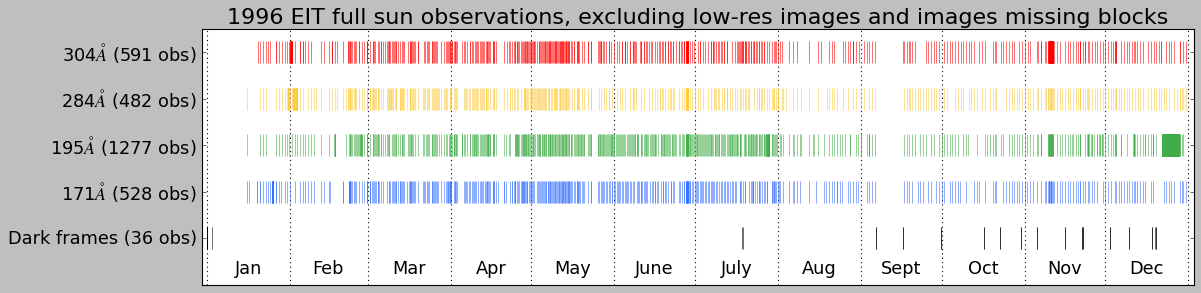

In [6]:
#for year in range(1996, 2010):
for year in [1996]:
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(year)
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    obsTimes_171 = []
    obsTimes_195 = []
    obsTimes_284 = []
    obsTimes_304 = []
    obsTimes_dark = []

    sci_objs = []
    dates = []
    fpaths = []
    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])
        #print(month)
        for d in days:
            #print(d)
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            for f in fitsFiles:
                #print(f.name)
                hdul = fits.open(f.path)
                header = hdul[0].header
                data = hdul[0].data
                #print(header['SCI_OBJ'])
                sci_objs.append(header['SCI_OBJ'])
                dates.append(header['DATE-BEG'])
                fpaths.append(f.path)

                sci_obj_ = header['SCI_OBJ'].replace("/"," ").replace(" ","_").lower()

                if "full_sun" in sci_obj_: 
                    try:
                        wavelength = header['WAVELNTH']
                    except KeyError:
                        print(sci_obj_)
                        print(repr(header))
    
                    #exclude lower-resolution or partial images and images with missing data blocks
                    if np.shape(data) == (1024,1024) and header['MSBLOCKS'] == 0:
                        if wavelength == 171:
                            obsTimes_171.append(header['DATE-BEG'])
                        if wavelength == 195:
                            obsTimes_195.append(header['DATE-BEG'])
                        if wavelength == 284:
                            obsTimes_284.append(header['DATE-BEG'])
                        if wavelength == 304:
                            obsTimes_304.append(header['DATE-BEG'])
    
                elif "dark_image" in sci_obj_:
                    #separate out what I assume are mis-labeled stray light images
                    if np.median(data) < 1000.:
                        #print(header['DATE-BEG'])
                        obsTimes_dark.append(header['DATE-BEG'])                    
    
    tDark = astropy.time.Time(obsTimes_dark, format='isot', scale='utc').jd
    t171 = astropy.time.Time(obsTimes_171, format='isot', scale='utc').jd
    t195 = astropy.time.Time(obsTimes_195, format='isot', scale='utc').jd
    t284 = astropy.time.Time(obsTimes_284, format='isot', scale='utc').jd
    t304 = astropy.time.Time(obsTimes_304, format='isot', scale='utc').jd

    fig, ax = plt.subplots(1,1,figsize=(16,4))

    runningdaycount = 0
    for i, d in enumerate(dayspermonth):
        ax.axvline(runningdaycount,color='k',ls=':')    
        ax.text(runningdaycount + d/2, -0.75, months[i],horizontalalignment='center',fontsize=16)
        runningdaycount = runningdaycount+d
        # leap years
        if year%4 == 0 and i==1:
            runningdaycount = runningdaycount + 1
    
    ax.plot(tDark-jan1_thisyear, np.zeros_like(tDark), ls='None',marker='|',ms=20,mec='k')
    ax.plot(t171-jan1_thisyear, np.ones_like(t171), ls='None',   marker='|',ms=20,mec='#3772ff')
    ax.plot(t195-jan1_thisyear, 2*np.ones_like(t195), ls='None', marker='|',ms=20,mec='#41ad49')
    ax.plot(t284-jan1_thisyear, 3*np.ones_like(t284), ls='None', marker='|',ms=20,mec='#fdca40')
    ax.plot(t304-jan1_thisyear, 4*np.ones_like(t304), ls='None', marker='|',ms=20,mec='r')
    #ax.set_xlabel('time', fontsize=16) #("BJD-2450083.5 [days since 01/01/{0} 00:00 UTC]".format(year),fontsize=16)
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels([r"Dark frames ({0} obs)".format(len(tDark)), 
                        r"171$\AA$ ({0} obs)".format(len(t171)),
                        r"195$\AA$ ({0} obs)".format(len(t195)),
                        r"284$\AA$ ({0} obs)".format(len(t284)),
                        r"304$\AA$ ({0} obs)".format(len(t304))],fontsize=16)
    ax.set_xticks([])
    ax.set_ylim(-1,4.5) 
    ax.set_xlim(-2,runningdaycount+2)
    
    ax.set_title(r'{0} EIT full sun observations, excluding low-res images and images missing blocks'.format(year),fontsize=20)
    #plt.show()
    plt.savefig("./EITschedule_{0}.pdf".format(year), bbox_inches="tight")


In [17]:
uniq_sci_objs = []
for i in range(len(sci_objs)):
    if sci_objs[i] not in uniq_sci_objs:
        #print(sci_objs[i])
        #print(dates[i])
        uniq_sci_objs.append(sci_objs[i])

print(len(uniq_sci_objs))

176
